In [1]:
import pandas as pd
import numpy as np

In [2]:
dynamic_data = pd.read_csv('sph_dynamic.csv')

In [3]:
static_data = pd.read_csv('sph_static.csv')

In [4]:
# Missing Values in Dynamic Table
dynamic_data.isnull().sum()

stay_id                   0
charttime                 0
total_protein          6930
calcium                 933
creatinine              261
glucose                 444
sodium                  214
chloride                241
heart_rate             6833
sbp                    6895
dbp                    6895
mbp                    6887
resp_rate              6832
temperature            6974
hemoglobin             1179
wbc                    1207
alt                    3964
ast                    3936
alp                    3976
bilirubin_total        3957
bilirubin_direct       6808
bilirubin_indirect     6812
ph                     7004
lactate                7012
pt                     3068
urineoutput            6942
sofa_respiration       7005
sofa_coagulation       7023
sofa_liver             7023
sofa_cardiovascular    6872
sofa_cns               6979
sofa_renal             7024
dtype: int64

In [5]:
# Drop the columns with more than 80%
for col in dynamic_data.columns:
    if dynamic_data[col].isnull().sum() > len(dynamic_data)*0.8:
        del dynamic_data[col]

In [6]:
dynamic_data.isnull().sum()

stay_id               0
charttime             0
calcium             933
creatinine          261
glucose             444
sodium              214
chloride            241
hemoglobin         1179
wbc                1207
alt                3964
ast                3936
alp                3976
bilirubin_total    3957
pt                 3068
dtype: int64

In [7]:
# ['alt','ast','alp','bilirubin_total','pt'] are liver function related test results
# create a new binary column 'liver_function_test', True/1 means have ever taken liver function test
liver_test_result = ['alt','ast','alp','bilirubin_total','pt']
def liver_categorize(group):
    flag = True
    for i in liver_test_result:
        if group[i].notnull().any():
            flag = False
    if flag:
        group['liver_function_test'] = False
    else:
        group['liver_function_test'] = True
    return group

dynamic_data = dynamic_data.groupby('stay_id').apply(liver_categorize)

In [8]:
dynamic_data

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,alt,ast,alp,bilirubin_total,pt,liver_function_test
0,35715575,2148-12-27 18:15:00.000,8.5,0.9,137.0,138.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,34483718,2118-01-04 03:58:00.000,8.2,0.8,129.0,141.0,101.0,8.7,11.3,NaN,NaN,NaN,NaN,12.1,True
2,31826892,2163-03-10 19:59:00.000,7.7,0.4,112.0,136.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,36154799,2131-12-02 19:14:00.000,NaN,NaN,NaN,NaN,NaN,12.3,NaN,NaN,NaN,NaN,NaN,NaN,True
4,32732521,2116-08-12 12:45:00.000,NaN,4.0,135.0,139.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,31292653,2192-03-18 03:14:00.000,NaN,1.4,102.0,137.0,103.0,8.7,4.9,NaN,NaN,NaN,NaN,NaN,True
7020,32964221,2127-01-30 10:00:00.000,8.6,0.5,112.0,139.0,107.0,8.9,14.3,14.0,32.0,148.0,2.6,NaN,True
7021,33493321,2142-07-28 06:02:00.000,NaN,1.1,130.0,142.0,105.0,8.4,4.0,NaN,NaN,NaN,NaN,NaN,True
7022,38658392,2189-05-17 00:13:00.000,7.3,1.0,174.0,133.0,93.0,13.0,19.5,9.0,18.0,48.0,0.5,13.0,True


In [9]:
dynamic_data.describe()

,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,alt,ast,alp,bilirubin_total,pt
count,7.024000e+03,6091.000000,6763.000000,6580.000000,6810.000000,6783.000000,5845.000000,5817.000000,3060.000000,3088.000000,3048.000000,3067.000000,3956.000000
mean,3.497892e+07,8.389640,1.644019,142.289666,137.309545,102.067079,10.043353,10.973130,161.859150,243.882772,131.933727,4.248745,18.826567
std,2.832325e+06,0.820066,1.839893,89.875986,5.638384,6.731008,2.177573,8.228807,752.898832,1216.527439,123.088598,7.808056,11.588015
min,3.000414e+07,4.200000,0.100000,30.000000,83.000000,62.000000,3.900000,0.100000,1.000000,5.000000,7.000000,0.100000,9.200000
25%,3.255070e+07,7.900000,0.800000,102.000000,134.000000,98.000000,8.400000,5.900000,17.000000,22.000000,65.000000,0.500000,12.800000
50%,3.496990e+07,8.400000,1.100000,125.000000,138.000000,102.000000,9.800000,9.400000,30.000000,42.000000,92.000000,1.000000,14.900000
75%,3.746081e+07,8.900000,1.800000,159.000000,141.000000,106.000000,11.400000,14.200000,62.000000,95.000000,149.000000,3.600000,20.400000
max,3.999217e+07,12.300000,19.700000,2970.000000,185.000000,153.000000,18.400000,125.200000,15018.000000,28275.000000,1185.000000,52.600000,150.000000


In [10]:
# Assume that patients with no relevant results recorded don't have liver issues
# so we impute these patients' missing values of these columns with random number in normal range

# but i can not find the unit and normal range for them so i drop them first >_<
# dynamic_data.drop(['alt','ast','alp','bilirubin_total','pt'], axis = 1, inplace = True)

In [11]:
dynamic_data.isnull().sum()

stay_id                   0
charttime                 0
calcium                 933
creatinine              261
glucose                 444
sodium                  214
chloride                241
hemoglobin             1179
wbc                    1207
alt                    3964
ast                    3936
alp                    3976
bilirubin_total        3957
pt                     3068
liver_function_test       0
dtype: int64

In [12]:
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'alt'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'ast'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'alp'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'bilirubin_total'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'pt'].describe())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: alt, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: ast, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: alp, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bilirubin_total, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: pt, dtype: float64


In [13]:
# use KNN to impute the rest
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 10)
dynamic_data.iloc[:,2:] = imputer.fit_transform(dynamic_data.iloc[:,2:])

In [14]:
# define normal ranges for each column
normal_ranges = {
    'alt': (5, 40),
    'ast': (10, 35),
    'alp': (40, 130),
    'bilirubin_total': (0.1, 1.0),
    'pt': (9.5, 13.5)
}


In [15]:
mask = dynamic_data['liver_function_test'] == False
n_no_test = mask.sum()
def sample_normal(col):
    lower = normal_ranges[col][0]
    upper = normal_ranges[col][1]
    return np.random.normal(loc=(lower+upper)/2, scale=(upper-lower)/6, size=n_no_test)

sampled_alt = sample_normal("alt")
sampled_ast = sample_normal("ast")
sampled_alp = sample_normal("alp")
sampled_bilirubin_total = sample_normal("bilirubin_total")
sampled_pt = sample_normal("pt")
dynamic_data.loc[mask, 'alt'] = sampled_alt
dynamic_data.loc[mask, 'ast'] = sampled_ast
dynamic_data.loc[mask, 'alp'] = sampled_alp
dynamic_data.loc[mask, 'bilirubin_total'] = sampled_bilirubin_total
dynamic_data.loc[mask, 'pt'] = sampled_pt

In [16]:
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'alt'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'ast'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'alp'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'bilirubin_total'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'pt'].describe())

count    349.000000
mean      22.681933
std        5.450843
min        7.751888
25%       19.038508
50%       22.791527
75%       26.285287
max       38.814059
Name: alt, dtype: float64
count    349.000000
mean      22.629555
std        4.330149
min        9.800937
25%       19.737673
50%       22.587928
75%       25.410166
max       39.906261
Name: ast, dtype: float64
count    349.000000
mean      85.049201
std       14.722107
min       32.837270
25%       75.026432
50%       84.949128
75%       94.216465
max      126.820282
Name: alp, dtype: float64
count    349.000000
mean       0.556228
std        0.157037
min        0.147357
25%        0.463130
50%        0.545822
75%        0.654332
max        1.029212
Name: bilirubin_total, dtype: float64
count    349.000000
mean      11.499813
std        0.652928
min        9.861557
25%       11.065988
50%       11.540726
75%       11.929559
max       13.637672
Name: pt, dtype: float64


In [17]:
#to address the same patinent have differrent results at the same charttime
dynamic_data = dynamic_data.groupby(['stay_id','charttime']).mean().reset_index()

In [18]:
#compute the gradient
def count_gradient(group):
    testresult = list(dynamic_data.columns)[2:-1]
    for i in testresult:
        if len(group) == 1:
            group[i+'_grad'] = 0
        else:
            time_diff = (group['charttime'].iloc[-1] - group['charttime'].iloc[-2]).total_seconds()
            group[i+'_grad'] = (group[i].iloc[-1] - group[i].iloc[-2]) / time_diff 
    return group

In [19]:
dynamic_data['charttime'] = pd.to_datetime(dynamic_data['charttime'])

In [20]:
dynamic_data.sort_values(by = ['stay_id','charttime'], inplace = True)
dynamic_data = dynamic_data.groupby('stay_id').apply(count_gradient)

In [21]:
# take the last values of all timepoints for each patient
dynamic_data_last = dynamic_data.drop(['charttime'],axis = 1).groupby('stay_id').tail(1)

In [22]:
# merge dynamic and static table
data = static_data.merge(dynamic_data_last, on = 'stay_id')

In [23]:
data

,stay_id,icu_intime,vent_start,vent_end,vent_duration,calcium,creatinine,glucose,sodium,chloride,...,glucose_grad,sodium_grad,chloride_grad,hemoglobin_grad,wbc_grad,alt_grad,ast_grad,alp_grad,bilirubin_total_grad,pt_grad
0,30004144,2126-04-04 13:20:25.000,4/5/26 16:00,4/6/26 17:00,25.000000,6.80,0.7,133.0,135.0,102.0,...,0.001466,0.000000,-0.000077,-0.000093,-0.000023,-0.000216,-0.001782,0.002238,0.000002,0.000093
1,30005366,2202-12-27 17:36:59.000,12/28/02 14:00,12/28/02 20:00,6.000000,8.80,6.7,41.0,139.0,100.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,30006983,2159-10-12 03:56:42.000,10/12/59 18:00,10/14/59 19:00,49.000000,7.10,1.0,89.0,136.0,108.0,...,-0.001230,0.000073,0.000110,-0.000015,0.000022,0.000055,0.000275,-0.000606,0.000004,0.000031
3,30023204,2124-07-09 16:43:55.000,7/11/24 16:00,7/12/24 16:10,24.166667,8.50,1.4,107.0,131.0,100.0,...,0.000403,-0.000050,-0.000201,0.000076,-0.000222,0.002110,0.001334,0.000534,-0.000062,-0.000226
4,30031418,2156-03-05 14:11:00.000,3/7/56 22:06,3/8/56 8:00,9.900000,7.40,0.4,133.0,139.0,106.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,39977971,2115-12-11 17:42:45.000,12/12/15 12:00,12/12/15 16:00,4.000000,8.90,2.2,98.0,132.0,97.0,...,-0.003474,0.000100,0.000033,-0.000037,-0.000017,-0.002295,0.000852,-0.000658,-0.000005,0.000010
1919,39982332,2180-03-01 22:35:04.000,3/2/80 19:00,3/3/80 8:00,13.000000,8.82,1.2,119.0,140.0,103.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1920,39985110,2141-03-03 05:57:46.000,3/4/41 20:44,3/6/41 4:00,31.266667,10.40,6.8,149.0,139.0,98.0,...,0.000425,0.000018,0.000000,0.000007,0.000052,0.000575,0.000778,-0.001323,0.000013,0.000032
1921,39986206,2183-06-19 23:25:31.000,6/20/83 22:00,6/30/83 4:00,222.000000,7.50,6.0,101.0,139.0,103.0,...,-0.000866,0.000000,0.000000,0.000017,-0.000039,0.002264,0.002580,0.003697,0.000011,0.000013


In [24]:
#Converting data type of icu_intime, vent_start and vent_end to date and time format
data['icu_intime'] = pd.to_datetime(data['icu_intime'])
data['vent_start'] = pd.to_datetime(data['vent_start'], format='%m/%d/%y %H:%M')
data['vent_end'] = pd.to_datetime(data['vent_end'], format='%m/%d/%y %H:%M')

In [25]:
data.dtypes

stay_id                          int64
icu_intime              datetime64[ns]
vent_start              datetime64[ns]
vent_end                datetime64[ns]
vent_duration                  float64
calcium                        float64
creatinine                     float64
glucose                        float64
sodium                         float64
chloride                       float64
hemoglobin                     float64
wbc                            float64
alt                            float64
ast                            float64
alp                            float64
bilirubin_total                float64
pt                             float64
liver_function_test            float64
calcium_grad                   float64
creatinine_grad                float64
glucose_grad                   float64
sodium_grad                    float64
chloride_grad                  float64
hemoglobin_grad                float64
wbc_grad                       float64
alt_grad                 

In [26]:
data

,stay_id,icu_intime,vent_start,vent_end,vent_duration,calcium,creatinine,glucose,sodium,chloride,...,glucose_grad,sodium_grad,chloride_grad,hemoglobin_grad,wbc_grad,alt_grad,ast_grad,alp_grad,bilirubin_total_grad,pt_grad
0,30004144,2126-04-04 13:20:25,2026-04-05 16:00:00,2026-04-06 17:00:00,25.000000,6.80,0.7,133.0,135.0,102.0,...,0.001466,0.000000,-0.000077,-0.000093,-0.000023,-0.000216,-0.001782,0.002238,0.000002,0.000093
1,30005366,2202-12-27 17:36:59,2002-12-28 14:00:00,2002-12-28 20:00:00,6.000000,8.80,6.7,41.0,139.0,100.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,30006983,2159-10-12 03:56:42,2059-10-12 18:00:00,2059-10-14 19:00:00,49.000000,7.10,1.0,89.0,136.0,108.0,...,-0.001230,0.000073,0.000110,-0.000015,0.000022,0.000055,0.000275,-0.000606,0.000004,0.000031
3,30023204,2124-07-09 16:43:55,2024-07-11 16:00:00,2024-07-12 16:10:00,24.166667,8.50,1.4,107.0,131.0,100.0,...,0.000403,-0.000050,-0.000201,0.000076,-0.000222,0.002110,0.001334,0.000534,-0.000062,-0.000226
4,30031418,2156-03-05 14:11:00,2056-03-07 22:06:00,2056-03-08 08:00:00,9.900000,7.40,0.4,133.0,139.0,106.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,39977971,2115-12-11 17:42:45,2015-12-12 12:00:00,2015-12-12 16:00:00,4.000000,8.90,2.2,98.0,132.0,97.0,...,-0.003474,0.000100,0.000033,-0.000037,-0.000017,-0.002295,0.000852,-0.000658,-0.000005,0.000010
1919,39982332,2180-03-01 22:35:04,1980-03-02 19:00:00,1980-03-03 08:00:00,13.000000,8.82,1.2,119.0,140.0,103.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1920,39985110,2141-03-03 05:57:46,2041-03-04 20:44:00,2041-03-06 04:00:00,31.266667,10.40,6.8,149.0,139.0,98.0,...,0.000425,0.000018,0.000000,0.000007,0.000052,0.000575,0.000778,-0.001323,0.000013,0.000032
1921,39986206,2183-06-19 23:25:31,1983-06-20 22:00:00,1983-06-30 04:00:00,222.000000,7.50,6.0,101.0,139.0,103.0,...,-0.000866,0.000000,0.000000,0.000017,-0.000039,0.002264,0.002580,0.003697,0.000011,0.000013


MSE: 3934.8089063290386
MAE: 36.70706038572814
R-squared: -0.02474518036439699


<AxesSubplot:xlabel='vent_duration'>

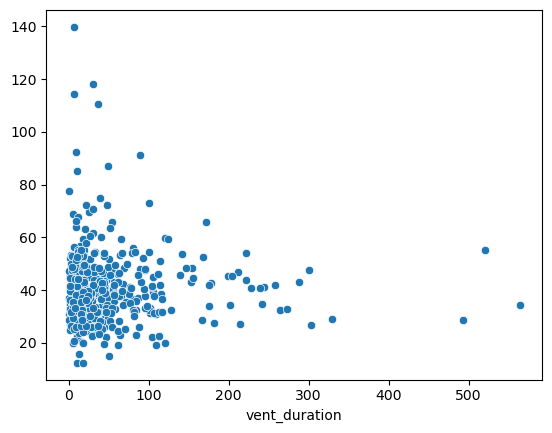

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
X = data.drop(['vent_duration', 'icu_intime', 'vent_start', 'vent_end'], axis=1)
y = data['vent_duration']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))
import seaborn as sns
sns.scatterplot(x=y_test, y=y_pred)


In [28]:
#Continuous RandomForest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))


MSE: 4153.5323346530695
MAE: 37.889540123010256
R-squared: -0.08170748383161519


In [29]:
# Continuous XGBoost

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


param_distributions = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

gb = XGBRegressor(random_state=42)

rs = RandomizedSearchCV(gb, param_distributions, n_iter=50, cv=5, random_state=42)
rs.fit(X_train, y_train)

print(rs.best_params_)

y_pred = rs.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))


{'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
MSE: 3987.8124120859843
MAE: 35.05555111597615
R-squared: -0.038548922390974516


In [30]:
# Continuous DNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Define model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile
model.compile(loss='mse', optimizer='adam')

# early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Training
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=32, callbacks=[early_stop])

# Evaluate on test
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))


Epoch 1/1000
43/43 [==============================] - 1s 10ms/step - loss: 4540.3081 - val_loss: 5282.9170
Epoch 2/1000
43/43 [==============================] - 0s 4ms/step - loss: 4334.4849 - val_loss: 5019.7251
Epoch 3/1000
43/43 [==============================] - 0s 5ms/step - loss: 3978.6487 - val_loss: 4635.0981
Epoch 4/1000
43/43 [==============================] - 0s 6ms/step - loss: 3573.0769 - val_loss: 4279.9888
Epoch 5/1000
43/43 [==============================] - 0s 5ms/step - loss: 3335.8042 - val_loss: 4089.7002
Epoch 6/1000
43/43 [==============================] - 0s 5ms/step - loss: 3229.3459 - val_loss: 4022.2349
Epoch 7/1000
43/43 [==============================] - 0s 5ms/step - loss: 3160.9224 - val_loss: 3992.3821
Epoch 8/1000
43/43 [==============================] - 0s 5ms/step - loss: 3111.2869 - val_loss: 3971.6252
Epoch 9/1000
43/43 [==============================] - 0s 4ms/step - loss: 3127.5464 - val_loss: 3976.9771
Epoch 10/1000
43/43 [========================

In [34]:
#cagegorical XGboost
from xgboost import XGBClassifier

# Categorize vent_duration 
data['vent_duration_category'] = pd.cut(data['vent_duration'], bins=[0, 24, 48, 72, np.inf], labels=['0-24 hours', '24-48 hours', '48-72 hours', 'over 72 hours'])

# train and test sets split
train_df = data.sample(frac=0.8, random_state=42)
test_df = data.drop(train_df.index)

X_train = scaler.fit_transform(train_df.drop(['icu_intime', 'vent_start', 'vent_end', 'vent_duration', 'vent_duration_category'], axis=1))
y_train = train_df['vent_duration_category']
X_test = scaler.fit_transform(test_df.drop(['icu_intime', 'vent_start', 'vent_end', 'vent_duration', 'vent_duration_category'], axis=1))
y_test = test_df['vent_duration_category']


In [35]:
from sklearn.preprocessing import LabelEncoder

# Encode the response variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train_encoded)

# Make predictions on test 
y_pred_xgb = xgb_model.predict(X_test)

# Decode the predictions
y_pred_decoded = label_encoder.inverse_transform(y_pred_xgb)
 

In [36]:
from sklearn.metrics import accuracy_score, f1_score

#evaluation metrics
print('XGBoost:')
print('Accuracy:', accuracy_score(y_test, y_pred_decoded))
print('F1 score:', f1_score(y_test, y_pred_decoded, average='weighted'))

XGBoost:
Accuracy: 0.5428571428571428
F1 score: 0.4287585179005203


In [37]:
# Categorical DNN 

# Define model 
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Training
model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=100, batch_size=32, callbacks=[early_stop])

# Evaluate on test set
y_pred_encoded = model.predict(X_test).argmax(axis=-1)
y_pred_decoded = label_encoder.inverse_transform(y_pred_encoded)

# evaluation metrics
print('DNN:')
print('Accuracy:', accuracy_score(y_test, y_pred_decoded))
print('F1 score:', f1_score(y_test, y_pred_decoded, average='weighted'))


Epoch 1/100
49/49 [==============================] - 1s 8ms/step - loss: 1.4879 - accuracy: 0.3739 - val_loss: 1.2388 - val_accuracy: 0.5714
Epoch 2/100
49/49 [==============================] - 0s 4ms/step - loss: 1.3444 - accuracy: 0.5176 - val_loss: 1.2077 - val_accuracy: 0.5766
Epoch 3/100
49/49 [==============================] - 0s 3ms/step - loss: 1.2483 - accuracy: 0.5423 - val_loss: 1.1926 - val_accuracy: 0.5766
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 1.2049 - accuracy: 0.5585 - val_loss: 1.1832 - val_accuracy: 0.5766
Epoch 5/100
49/49 [==============================] - 0s 4ms/step - loss: 1.2141 - accuracy: 0.5637 - val_loss: 1.1819 - val_accuracy: 0.5766
Epoch 6/100
49/49 [==============================] - 0s 4ms/step - loss: 1.2062 - accuracy: 0.5741 - val_loss: 1.1756 - val_accuracy: 0.5766
Epoch 7/100
49/49 [==============================] - 0s 4ms/step - loss: 1.1738 - accuracy: 0.5800 - val_loss: 1.1701 - val_accuracy: 0.5766
Epoch 8/100
4